Inception Example
=========

This ipython notebook shows a quick example on how to run the inception model that we provided for image classification. This pre-trained network is provided as a reference model for the CVPR 2015 publication:

Christian Szegedy, Wei Liu, Yangqing Jia, Pierre Sermanet, Scott Reed,
Dragomir Anguelov, Dumitru Erhan, Vincent Vanhoucke, Andrew Rabinovich.
Going Deeper with Convolutions, CVPR 2015. [pdf](http://www.cv-foundation.org/openaccess/content_cvpr_2015/papers/Szegedy_Going_Deeper_With_2015_CVPR_paper.pdf)

Dependencies
--------------
This notebook is designed to have as few dependencies as possible:
* Standard Python scientific stack: NumPy, Matplotlib, scikits-image, IPython. Those libraries can also be installed as a part of one of the scientific packages for Python, such as Anaconda or Canopy.
* Google protobuf library for Python.
* Caffe2 deep learning framework (installation instructions), which can be obtained at [this address](http://github.com/Yangqing/caffe2/). The reason we did not use Caffe is that some specifications of our system at Google does not use the Caffe convention. For example, the data is stored in the order height-width-channel instead of channel-height-width, and the padding convention is slightly different. Caffe2 provides a compatible implementation that matches our model.

In [1]:
from IPython import display
from matplotlib import pyplot
import numpy as np
import os
import sys
%matplotlib inline

# Make sure that you set this to the location your caffe2 library lies.
caffe2_root = '/home/user/caffe2-release/'
sys.path.insert(0, os.path.join(caffe2_root, 'gen'))

# After setting the caffe2 root path, we will import all the caffe2 libraries needed.
from caffe2.proto import caffe2_pb2
from pycaffe2 import core, net_drawer, workspace, visualize

loaded nvd3 IPython extension
run nvd3.IPython_wrapper.initialize_javascript() to set up the notebook
help(nvd3.IPython_wrapper.initialize_javascript) for options
Couldn't import dot_parser, loading of dot files will not be possible.


(note: if you see warning messages above, it might be coming from some dependency libraries like pydot, and you do not need to worry about it.)

Loading the model
-------------------
First, let's load the inception model. It is composed of two parts: one defines the network architecture, and one provides the parameters that the network uses.

In [2]:
# net is the network definition.
net = caffe2_pb2.NetDef()
net.ParseFromString(open('inception_net.pb').read())
# tensors contain the parameter tensors.
tensors = caffe2_pb2.TensorProtos()
tensors.ParseFromString(open('inception_tensors.pb').read())

Let's take a look at the model architecture using Caffe2's net_drawer. Warning: this network is very deep, so you might need to scroll down to show the whole network. To assist your scroll, we are showing the flow direction from the top to the bottom, so the input image is filled into the top of the graph. Each node in this graph is an operator (loosely equivalence of a layer). We are showing activations like ReLU as layers as well. The type of the operators are shown in the name of each node.

The graph is quite tall, so you may need to scroll down.

Visualizing network: inception


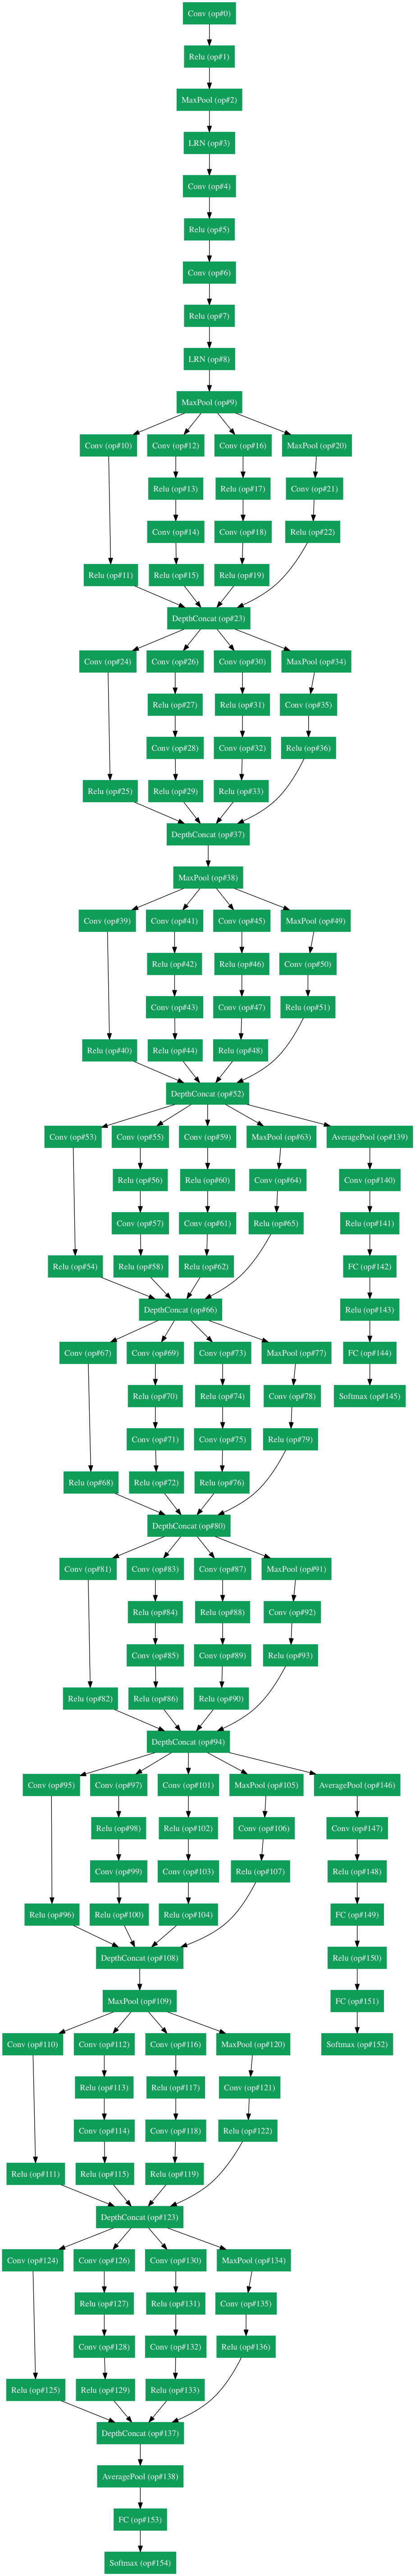

In [3]:
# Note that the following line hides the intermediate blobs and only shows the operators.
# If you want to show all the blobs as well, use the commented GetPydotGraph line.
graph = net_drawer.GetPydotGraphMinimal(net.op, name="inception", rankdir='TB')
#graph = net_drawer.GetPydotGraph(net.op, name="inception", rankdir='TB')

print 'Visualizing network:', net.name
display.Image(graph.create_png(), width=200)

If the image shown above is too small, try right-click it and select "Open image in new tab". This will show a larger version. You may notice the two "side towers" branching out, and ending with names "softmax0" and "softmax1": as described in our paper, such side towers exist to help making models converging faster. In practice, when you are doing inference (as in this example, you do not need to use these side towers. We are leaving them here just for completeness, since we do not care too much about speed for this example.

Instantiate the Model in Caffe2
------------------------------------
If you are familiar with Caffe, you may notice that Caffe2 instantiates a model slightly differently - it deals with the network and the parameters separately, and has a specific device_option field that specifies where to run the model. This allows one to have more fine-grained control over things.

In [4]:
DEVICE_OPTION = caffe2_pb2.DeviceOption()
# Let's use CPU in our example.
DEVICE_OPTION.device_type = caffe2_pb2.CPU

# If you have a GPU and want to run things there, uncomment the below two lines.
# If you have multiple GPUs, you also might want to specify a gpu id.
#DEVICE_OPTION.device_type = caffe2_pb2.CUDA
#DEVICE_OPTION.cuda_gpu_id = 0

# Caffe2 has a concept of "workspace", which is similar to that of Matlab. Each workspace
# is a self-contained set of tensors and networks. In this case, we will just use the default
# workspace so we won't dive too deep into it.
workspace.SwitchWorkspace('default')

# First, we feed all the parameters to the workspace.
for param in tensors.protos:
    workspace.FeedBlob(param.name, param, DEVICE_OPTION)
# The network expects an input blob called "input", which we create here.
# The content of the input blob is going to be fed when we actually do
# classification.
workspace.CreateBlob("input")
# Specify the device option of the network, and then create it.
net.device_option.CopyFrom(DEVICE_OPTION)
workspace.CreateNet(net)

True

Now let's do some classification on images. There are a lot of tricks that one can employ in image pre-processing, and one often employs multiple cropping strategies in order to increase testing performance. Here we just do a very simple example: we resize the center square region of the image to 224x224, which is the input size expected by the network, and subtract the mean value 117 (which is a hyperparameter we used in training), and directly feeds it to the network. For simplicity, we will write a function that wraps all these.

In [5]:
def ClassifyImageWithInception(image_file, show_image=True, output_name="softmax2"):
    from skimage import io, transform
    img = io.imread(image_file)
    # Crop the center
    shorter_edge = min(img.shape[:2])
    crop_height = (img.shape[0] - shorter_edge) / 2
    crop_width = (img.shape[1] - shorter_edge) / 2
    cropped_img = img[crop_height:crop_height + shorter_edge, crop_width:crop_width + shorter_edge]
    # Resize the image to 224 * 224
    resized_img = transform.resize(cropped_img, (224, 224))
    if show_image:
        pyplot.imshow(resized_img)
    # normalize the image and feed it into the network. The network expects
    # a four-dimensional tensor, since it can process images in batches. In our
    # case, we will basically make the image as a batch of size one.
    normalized_img = resized_img.reshape((1, 224, 224, 3)).astype(np.float32) * 256 - 117
    workspace.FeedBlob("input", normalized_img, DEVICE_OPTION)
    workspace.RunNet("inception")
    return workspace.FetchBlob(output_name)

# We will also load the synsets file where we can look up the actual words for each of our prediction.
synsets = [l.strip() for l in open('synsets.txt').readlines()]

We will use a nice Dalmatian image to show how we run a simple prediction.

Prediction: 41, synset n02110341 dalmatian, coach dog, carriage dog


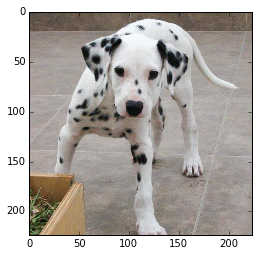

In [6]:
predictions = ClassifyImageWithInception("dog.jpg").flatten()
idx = np.argmax(predictions)
print 'Prediction: %d, synset %s' % (idx, synsets[idx])

Let's also show the top five predictions that we had, and the distribution of scores. A little bit more information for the keen readers: Our model is trained with a dummy class at index 0, which never gets used. This is in order to be consistent with the Matlab indexing convention, which starts with 1. The total number of predictions is actually 1008 classes. In case you are wondering, class 1001-1007 are also dummy, we used 1008 instead of 1001 just to make numerical optimization better for historical reasons. In practice, only the indices 1 to 1000 are going to have nontrivial predictions, since class 0 and 1001-1007 never have positive examples during training.

Top five predictions:
    41 (prob 0.9999) synset n02110341 dalmatian, coach dog, carriage dog
    17 (prob 0.0000) synset n02109047 Great Dane
     2 (prob 0.0000) synset n02100735 English setter
   588 (prob 0.0000) synset n03803284 muzzle
   134 (prob 0.0000) synset n02100236 German short-haired pointer


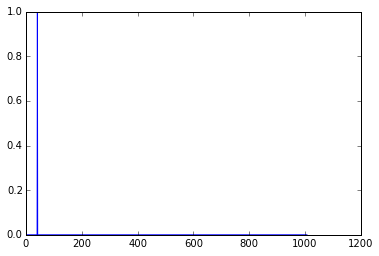

In [7]:
indices = np.argsort(predictions)
print 'Top five predictions:'
for idx in indices[:-6:-1]:
    print '%6d (prob %.4f) synset %s' % (idx, predictions[idx], synsets[idx])
pyplot.plot(predictions)

We can also inspect the intermediate results and parameters of the network, similar to what one can do in Caffe. Let's show the first layer filters, for example.

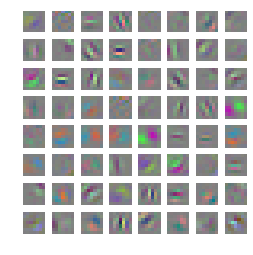

In [8]:
filters = workspace.FetchBlob('conv2d0_w')
# We normalize the filters for visualization.
filters = (filters - filters.min()) / (filters.max() - filters.min())
_ = visualize.PatchVisualizer(gap=2).ShowMultiple(filters, bg_func=np.max)

And let's show the first layer outputs. Since there are 64 output channels, we will only show the first 16 channels. The output are real-valued, but we will use pyplot's "hot" colormap so we can see the values better than grayscale.

First layer output shape: (1, 112, 112, 64)


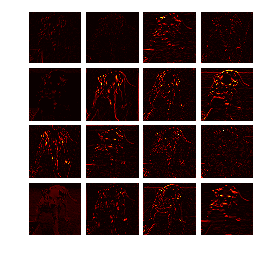

In [9]:
conv2d0 = workspace.FetchBlob('conv2d0')
print 'First layer output shape:', conv2d0.shape
_ = visualize.PatchVisualizer(gap=10).ShowChannels(conv2d0[0, :, :, :16], bg_func=np.max, cmap=pyplot.cm.hot)

Such activations go on and on, and for simplicity, let's just show the output of the last convolution, right before the average pooling layer. The layer has 1024 channels, so we will be only showing the first 144 channels.

First layer output shape: (1, 7, 7, 1024)


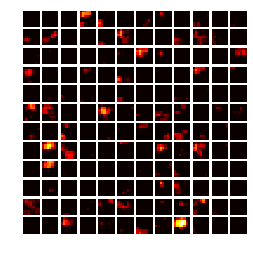

In [10]:
mixed5b = workspace.FetchBlob('mixed5b')
print 'First layer output shape:', mixed5b.shape
visualize.ShowChannels(mixed5b[0, :, :, :144], bg_func=np.max, cmap=pyplot.cm.hot)